In [1]:
#Mount drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Necessary installations
!pip install tld
!pip install pandas==1.0.5

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tld import get_tld
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import pickle
import glob
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Feminist quotes

In order to obtain the quotes only related to feminism we need to preprocess the data, using the functions defined below.

In [4]:
#we will only keep quotes that have words related to feminism
key_words = set(["feminism", "patriarchy", "sexism", "misogyny", "misandry", 
            "gynocentrism", "misogynoir", "phallocentrism", "rape culture", 
            "slut shaming", "women’s rights", "toxic masculinity", "male gaze", 
            "gender apartheid", "gender neutrality","gender equality", "glass ceiling",
            "male as norm", "male privilege", "manspreading", "girl power",
            "sexual objectification", "sexual harassment"])

DATASET_PATH = "/content/drive/MyDrive/ADA/Quotebank"
PICKLE_PATH = "/content/drive/MyDrive/ADA/pickles/feminist quotes"

In [5]:
def preprocess(chunk):  
  """return the chunk that had only those quotes
     that contain one of the keywords
  """
  #Take only quotes with attributed speaker
  chunk = chunk.loc[chunk["speaker"] != "None"]

  #Filter the data with keywords
  #make quote lowercase, tokenize it, convert to a set and intersect with set of keywords
  chunk = chunk[chunk["quotation"].apply(lambda x : (len(set(nltk.word_tokenize(x.lower()))
                                                        .intersection(key_words)) != 0))]
  
  #TODO: maybe remove that
  print("Number of filtered quotes found: ", len(chunk))

  return chunk

It is computationally expensive to preprocess the Quotebank data for all years (2015-2020) at once. Therefore, each member of the group preprocessed one ore two years and created the corresponding pickle containing the filtered data. The function below preprocesses all data, therefore we do not call it. Each member ran this code for one or two years.

In [6]:
def filter_feminism_data():

  used_cols = ["quoteID", "quotation", "date", "speaker", "qids", "numOccurrences", "urls"]

  #depends on hardware
  CHUNK_SIZE = 1000000

  #file_names will contain a touple with the path to the quotebank data of a year
  #and the path to the corresponding pickle for all years (2015-2020)
  files_names = []
  for _, name in enumerate(glob.glob(DATASET_PATH + "/*.bz2")):
    pickle_name = name.split('/')[6].split('.')[0]
    files_names.append((name, PICKLE_PATH + "/" + "processed_" + pickle_name + ".pkl"))

  #iterate over all available compressed files in chunks, preprocess them and pickle them
  for f_name in files_names:
    input_file = f_name[0]
    output_file = f_name[1]
    chunks = pd.read_json(input_file, chunksize=CHUNK_SIZE, lines=True, compression='bz2')
    with open(output_file, 'wb') as file:
      for chunk in chunks:
        chunk = chunk[used_cols]
        chunk = preprocess(chunk)
        pickle.dump(chunk, file)

Now that we have all the filterd data as pickles by years, we can load them and store them in a single dataframe.

In [7]:
#dataframe containing all feminism related data
chunk_dfs = []

for _, pickle_file in enumerate(glob.glob(PICKLE_PATH + "/*")):
  #make several calls to pickle.load(file), every call will return one object in the dumped order
  #append all the dataframe to small_dfs, then concatenate them
  with open(pickle_file, 'rb') as f:
    while 1:
      try:
        chunk_dfs.append(pickle.load(f))
      except EOFError:
        break
  #Concatenate the chunk_dfs
  feminism_df = pd.concat(chunk_dfs, axis=0, ignore_index=True)

In [8]:
print("The feminism related data has", feminism_df.shape[0], "samples.")

The feminism related data has 20052 samples.


In [9]:
#show feminist quotes dataset
feminism_df.head()

,quoteID,quotation,date,speaker,qids,numOccurrences,urls
0,2020-04-07-043408,So I started to think about that and landed on...,2020-04-07 11:00:00,Moya Bailey,[Q22279304],1,[http://feeds.mashable.com/~r/Mashable/~3/omNr...
1,2020-02-20-072693,There are many grounds on which to object to T...,2020-02-20 13:20:00,Jonathan Chait,[Q6272737],1,[https://www.vox.com/2020/2/20/20954059/libera...
2,2020-03-05-028330,I think that today in the former Soviet Union ...,2020-03-05 13:19:34,Dinara Saduakassova,[Q18388576],1,[http://cms.trust.org/item/20200305112901-pj26i/]
3,2020-03-16-048736,"She faces sexism and gross behaviour, only she...",2020-03-16 18:30:00,Sarah J. Maas,[Q20640708],1,[http://www.telegraph.co.uk/women/life/bestsel...
4,2020-01-29-033647,I had a simple notion of a regular small-town ...,2020-01-29 01:55:49,Abhishek Chaubey,[Q4667464],1,[https://indianexpress.com/article/entertainme...


We can look at the words used in the quotes and their frequencies by visualising them using a wordcloud.

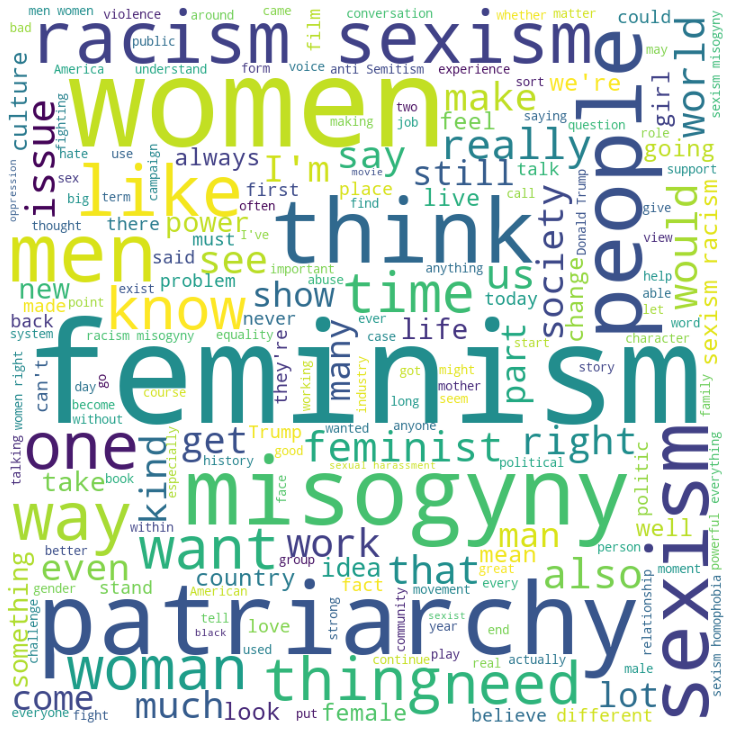

In [10]:
#join all quotations
joined_quotations_text = ' '.join(feminism_df["quotation"])

#define set of stopwords like the, than, of, etc.
stop_words = set(stopwords.words('english'))

#create
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(joined_quotations_text) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#Ranking the media outlets by number of quotes

In [11]:
# dictionary containing media outlets associating with the count of their quotes
quotes_count_per_media = {}

In [12]:
# url pattern
regex = '^(?:https?:\/\/)?(?:[^@\/\n]+@)?(?:www\.)?([^:\/?\n]+)'

def extract_media(url):
  """extract media outlet from url and update counts """
  media = re.search(regex, url).group(1)
  
  # update count
  count = quotes_count_per_media.get(media, 0)
  quotes_count_per_media[media] = count + 1
    
  # return media
  return media

In [13]:
def count_quotes_per_media(chunk):
  """ count the quotes per media outlets """
  # extract the media outlet(s)
  quote_medias = chunk.apply(lambda urls: [extract_media(url) for url in urls])

In [14]:
def create_media_rankings():
  """ create csv files that contain media outlets and corresponding number of quotes by year"""
  CHUNK_SIZE = 500000
  DATASET_PATH = "/content/drive/MyDrive/ADA/Quotebank"
  CSV_PATH = "/content/drive/MyDrive/ADA/pickles/media quotes counts"

  files_names = []
  for _, name in enumerate(glob.glob(DATASET_PATH + "/*.bz2")):
    pickle_name = name.split('/')[6].split('.')[0]
    files_names.append((name, CSV_PATH + "/" + "processed_" + pickle_name + ".pkl"))

  for f_name in files_names:
    input_file = f_name[0]
    output_file = f_name[1]
    chunks = pd.read_json(input_file, chunksize=CHUNK_SIZE, lines=True, compression='bz2')
    with open(output_file, 'wb') as file:
      for chunk in chunks:
        chunk = chunk['urls']
        count_quotes_per_media(chunk)
        
    #sort in descending order
    quotes_count_per_media = sorted(quotes_count_per_media.items(), key = lambda x: x[1], reverse=True)
    #create dataframe
    quotes_count_per_media_df = pd.DataFrame(quotes_count_per_media, columns=['media', 'count'])

    quotes_count_per_media_df.to_csv(output_file)

# Import additional dataset - Wikidata

We want to enrich the quotebank with an additional dataset that provides metadata about the speakers.

In [15]:
#import the parquet file and show first rows
WIKIDATA_PATH = "/content/drive/MyDrive/ADA/Project datasets/"
wikidata = pd.read_parquet(WIKIDATA_PATH + 'speaker_attributes.parquet')
wikidata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [16]:
wikidata.shape

(9055981, 15)

This dataset has a considerable amount of rows.

The QIDs are uniterpretable, so we map them to human readable labels.

In [17]:
#import csv that contains QIDs and respective label and show first rows
wikidata_labels = pd.read_csv(WIKIDATA_PATH + 'wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
wikidata_labels.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [18]:
#example for gender
wikidata_labels.loc['Q6581072'].Label

'female'

In [19]:
#example for ethnic group
wikidata_labels.loc['Q7994501'].Label

'White British'

In [20]:
#example for nationality
wikidata_labels.loc['Q145'].Label

'United Kingdom'

For some analysis we will need the gender corresponding to every speaker in a given subset of Quotebank. We can use the Wikidata to obtain this information by using the qids of each speaker. Qids are Wikidata IDs of all aliases that match the selected speaker. Therefore, each speaker may have a single or several aliases. After inspection of the Wikidata (see above), each alias can have None, one or several genders. Therefore, for each speaker, we will look at the genders of its aliases. If one alias has None or several genders, the corresponing speaker will have None in its gender column. Otherwise (alias has a single gender), we look at the genders of all aliases and if all the aliases have the same gender, then we set this gender for the speaker, otherwise it is None. 